In [1]:
import os
import cv2
import numpy as np
import string
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional

from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax

from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm
from collections import Counter

from PIL import Image

In [2]:
tf.__version__
# !ls

'2.9.0'

In [2]:
def generate_data(path):
  # Function that splits training path and annotations in 2 different lists.
  _path = []
  _label = []
  with open(path) as _data:
    for line in _data:
      temp = np.array(line.split())
      _path.append(temp[0])
      _label.append(temp[1])
  return _path, _label

In [3]:
train_path, train_label = generate_data("train.txt")
# train_path[:10], train_label[:10]

In [4]:
val_path, val_label = generate_data("val.txt")
# val_path[:10], val_label[:10]

In [5]:
test_path, test_label = generate_data("test.txt")

In [19]:
val_path, val_label = generate_data("val.txt")

In [6]:
# Code that generates a list of all the available characters in the dataset.
temp_vocab = []
with open("hindi_vocab.txt") as hindi_voc:
  for char in hindi_voc:
    temp = np.array(char.split("\n"))
    temp_vocab.append(temp[0])
vocab = set("".join(map(str, temp_vocab)))
print(sorted(vocab))
print(len(vocab))

['-', 'ँ', 'ं', 'ः', 'ऄ', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ऌ', 'ऍ', 'ऎ', 'ए', 'ऐ', 'ऑ', 'ऒ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'ऩ', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ऱ', 'ल', 'ळ', 'ऴ', 'व', 'श', 'ष', 'स', 'ह', '़', 'ऽ', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'ॄ', 'ॅ', 'ॆ', 'े', 'ै', 'ॉ', 'ॊ', 'ो', 'ौ', '्', 'ॐ', '॑', '॒', '॓', '॔', 'क़', 'ख़', 'ग़', 'ज़', 'ड़', 'ढ़', 'फ़', 'य़', 'ॠ', 'ॡ', 'ॢ', '।', '॥', '०', '१', '२', '३', '४', '५', '६', '७', '८', '९', '॰', 'ॱ', 'ॲ', 'ॻ', 'ॼ', 'ॽ', 'ॾ', 'ॿ']
112


In [7]:
Counter("".join(map(str, temp_vocab)))

Counter({'ा': 6096,
         'र': 4452,
         '्': 4323,
         'ि': 2847,
         'न': 2835,
         'क': 2714,
         'त': 2507,
         'े': 2471,
         'स': 2461,
         'ं': 2414,
         'ी': 2328,
         'ल': 2162,
         'म': 2104,
         'प': 1757,
         'ो': 1733,
         'व': 1651,
         'य': 1640,
         'द': 1442,
         'ज': 1296,
         'ग': 1280,
         'ब': 1243,
         'ु': 1232,
         'ह': 1116,
         'ट': 1031,
         'श': 790,
         'च': 760,
         'ड': 726,
         'ू': 674,
         'अ': 559,
         'ख': 493,
         'ध': 490,
         '़': 453,
         'भ': 441,
         'फ': 410,
         '-': 398,
         '।': 396,
         'ए': 391,
         'आ': 373,
         'ष': 371,
         'ै': 358,
         'ण': 293,
         'इ': 291,
         'उ': 260,
         'थ': 246,
         'ई': 212,
         'छ': 193,
         'ौ': 188,
         'ँ': 176,
         'ठ': 173,
         'घ': 156,
         'ओ': 142,
       

In [8]:
char_list = sorted(vocab)

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
        
    return dig_lst

In [9]:
encode_to_labels("छू")

[27, 64]

In [10]:
len(train_path), len(val_path)

(69853, 12708)

In [11]:
max_label_len = max([len(str(text)) for text in temp_vocab])
max_label_len

23

In [12]:
class My_Generator(Sequence):


  def __init__(self, image_filenames, labels, batch_size):
    self.image_filenames, self.labels = image_filenames, labels
    self.batch_size = batch_size

  def __len__(self):
    return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

  def __getitem__(self, idx):
    batch_paths = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
    batch_texts = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
    images = []
    training_txt = []
    train_label_length = []
    train_input_length = []

    for im_path, text in zip(batch_paths, batch_texts):
      try:
        text = str(text).strip()
        img = cv2.cvtColor(cv2.imread("HindiSeg/"+im_path), cv2.COLOR_BGR2GRAY)   

        ### actually returns h, w
        h, w = img.shape

        ### if height less than 32
        if h < 32:
          add_zeros = np.ones((32-h, w)) * 255
          img = np.concatenate((img, add_zeros))
          h = 32

        ## if width less than 128
        if w < 128:
          add_zeros = np.ones((h, 128-w)) * 255
          img = np.concatenate((img, add_zeros), axis=1)
          w = 128

        ### if width is greater than 128 or height greater than 32
        if w > 128 or h > 32:
          img = cv2.resize(img, (128, 32))

          img = np.expand_dims(img , axis = 2)

          # Normalize each image
          img = img / 255.

          images.append(img)
          training_txt.append(encode_to_labels(text))
          train_label_length.append(len(text))
          train_input_length.append(31)
      except:
        pass

    return [np.array(images), 
               pad_sequences(training_txt, maxlen=max_label_len, padding='post', value=len(char_list)), 
               np.array(train_input_length), 
               np.array(train_label_length)], np.zeros(len(images))

In [13]:
train_path[:10], train_label[:10]

(['HindiSeg/train/8/251/21.jpg',
  'HindiSeg/train/10/207/8.jpg',
  'HindiSeg/train/10/31/19.jpg',
  'HindiSeg/train/5/246/23.jpg',
  'HindiSeg/train/8/266/25.jpg',
  'HindiSeg/train/1/20/10.jpg',
  'HindiSeg/train/5/18/4.jpg',
  'HindiSeg/train/5/29/25.jpg',
  'HindiSeg/train/8/161/2.jpg',
  'HindiSeg/train/8/275/26.jpg'],
 ['केंद्रों',
  'पॉवर',
  'तरक्की',
  'मजा',
  'मांजने',
  'संबन्धित',
  'संभावनाएं',
  'आगे',
  'ज़ाद',
  'फ़त्तू'])

In [14]:
# !nvidia-smi

In [22]:
batch_size = 256
train_generator = My_Generator(train_path, train_label, batch_size)
val_generator = My_Generator(val_path, val_label, batch_size)


In [15]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32, 128, 1))

conv_1 = Conv2D(16, (3,3), activation = 'relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(32, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(64, (3,3), activation = 'relu', padding='same')(pool_2)
conv_4 = Conv2D(64, (3,3), activation = 'relu', padding='same')(conv_3)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(64, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(64, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(64, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(squeezed)
blstm_2 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(blstm_1)

outputs = Dense(len(char_list) + 1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [17]:
act_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 16)       160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 32, 32)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 32, 64)         18496 

In [16]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
loss_out = Lambda(ctc_lambda_func, 
                  output_shape=(1,), 
                  name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [17]:
file_path = "CLSTMCTC_best.hdf5"

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'Adam')

checkpoint = ModelCheckpoint(filepath=file_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

callbacks_list = [checkpoint]

In [20]:
epochs = 25

Hindi = model.fit(train_generator, 
                    epochs = epochs,
                    steps_per_epoch = len(train_path) // batch_size,
                    validation_data=val_generator,
                    validation_steps = len(val_path) // batch_size,
                    verbose = 1,
                    callbacks = callbacks_list,
                    shuffle=True)

Epoch 1/25
272/272 [==============================] - ETA: 0s - loss: 23.8117
Epoch 1: val_loss improved from inf to 25.03983, saving model to CLSTMCTC_best.hdf5
272/272 [==============================] - 543s 2s/step - loss: 23.8117 - val_loss: 25.0398
Epoch 2/25
272/272 [==============================] - ETA: 0s - loss: 20.4053
Epoch 2: val_loss improved from 25.03983 to 22.60396, saving model to CLSTMCTC_best.hdf5
272/272 [==============================] - 568s 2s/step - loss: 20.4053 - val_loss: 22.6040
Epoch 3/25
272/272 [==============================] - ETA: 0s - loss: 16.6289
Epoch 3: val_loss did not improve from 22.60396
272/272 [==============================] - 572s 2s/step - loss: 16.6289 - val_loss: 25.5836
Epoch 4/25
272/272 [==============================] - ETA: 0s - loss: 10.1807
Epoch 4: val_loss improved from 22.60396 to 9.68571, saving model to CLSTMCTC_best.hdf5
272/272 [==============================] - 518s 2s/step - loss: 10.1807 - val_loss: 9.6857
Epoch 5/25
2

In [28]:
# model.save_weights("CLSTMCTC_weights.hdf5")
# save in json format
model_json = model.to_json()
with open("CLSTMCTC_model.json", "w") as json_file:
  json_file.write(model_json)

In [23]:
eval = model.evaluate(val_generator, steps = len(val_path) // batch_size)

49/49 [==============================] - 102s 2s/step - loss: 125.8757


In [24]:
eval

125.8757095336914

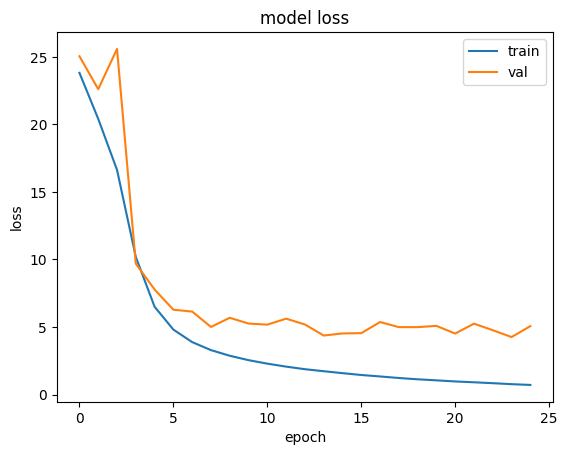

In [25]:
plt.plot(Hindi.history['loss'])
plt.plot(Hindi.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.savefig('loss.png')
plt.show()

Testing the model.

1. Load the weights from the trained model.
2. Send the image for testing.

In [25]:
def pre_process_image(path):

  img = cv2.cvtColor(cv2.imread("HindiSeg/"+path), cv2.COLOR_BGR2GRAY)

  # img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
  ### actually returns h, w
  h, w = img.shape

  ### if height less than 32
  if h < 32:
    add_zeros = np.ones((32-h, w)) * 255
    img = np.concatenate((img, add_zeros))
    h = 32

  ## if width less than 128
  if w < 128:
    add_zeros = np.ones((h, 128-w)) * 255
    img = np.concatenate((img, add_zeros), axis=1)
    w = 128

  ### if width is greater than 128 or height greater than 32
  if w > 128 or h > 32:
    img = cv2.resize(img, (128, 32))

    
  img = np.expand_dims(img , axis = 2)

  # Normalize each image
  img = img / 255.
    
  return img

In [26]:
# Loading the weights of pre-trained model.
act_model.load_weights('CLSTMCTC_best.hdf5')

In [28]:
def predict_output(img):
    # predict outputs on validation images
    prediction = act_model.predict(np.array([img]))
    ## shape (batch_size, num_timesteps, vocab_size)

    # use CTC decoder
    out = K.get_value(K.ctc_decode(prediction, 
                                   input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                                   greedy=True)[0][0])
    # get output using beam search
    out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0]) * prediction.shape[1], greedy=True, beam_width=10, top_paths=10)[0][0]) 

    


    ## get the final text    
    for x in out:

        print("predicted text = ", end = '')

        for p in x:

            if int(p) != -1:
                print(char_list[int(p)], end = '')
        
        print('\n')

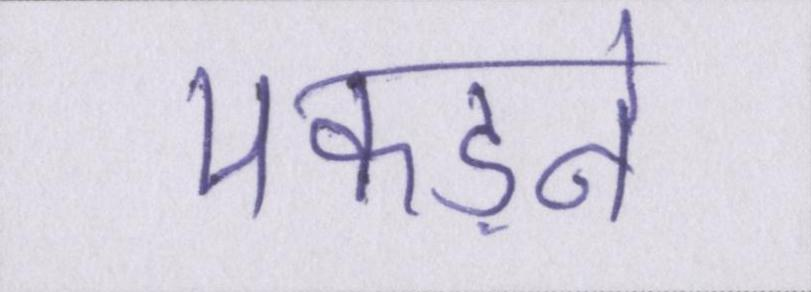



1/1 [==============================] - 1s 896ms/step
predicted text = पकड़ने



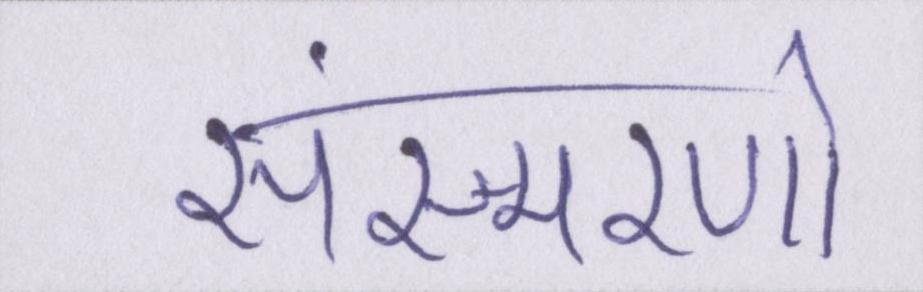



1/1 [==============================] - 0s 29ms/step
predicted text = संस्यरणो



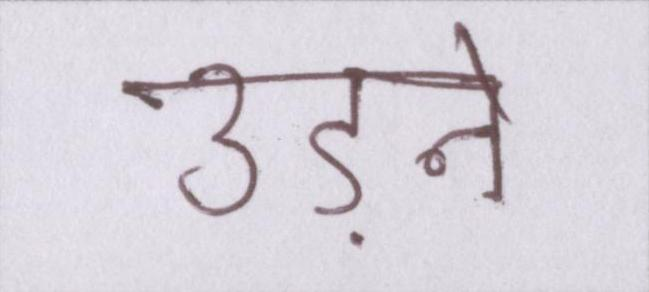



1/1 [==============================] - 0s 25ms/step
predicted text = उड़ने



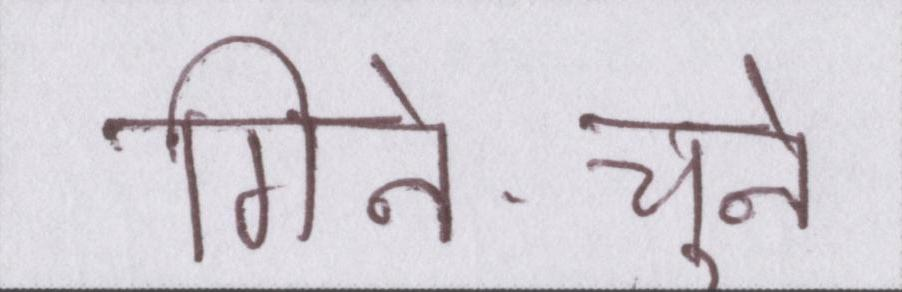



1/1 [==============================] - 0s 19ms/step
predicted text = गिने-चुने



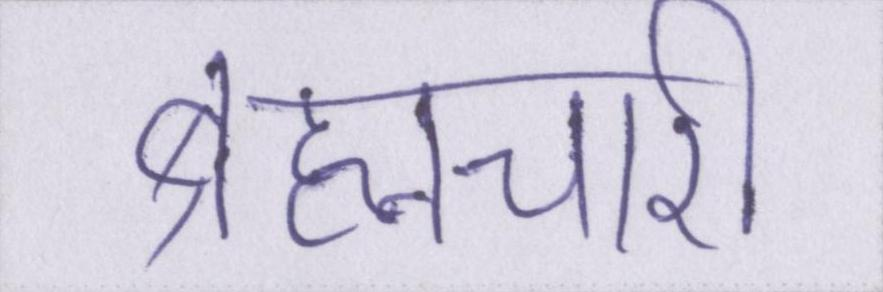



1/1 [==============================] - 0s 25ms/step
predicted text = श्र्म्चारी



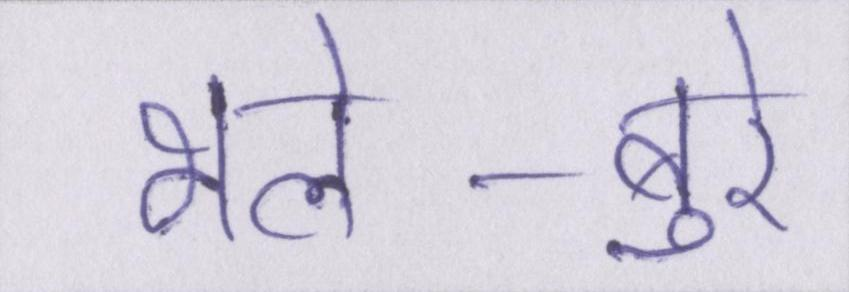



1/1 [==============================] - 0s 30ms/step
predicted text = अले-बुरे



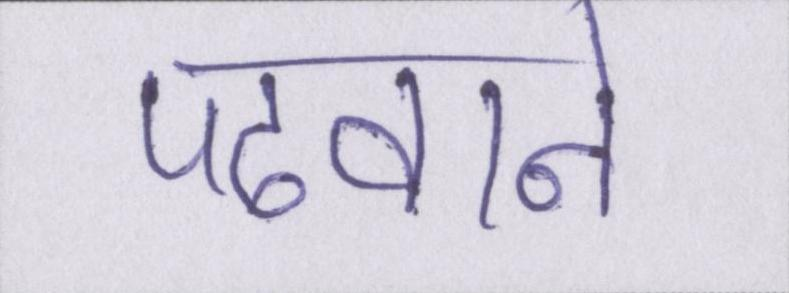



1/1 [==============================] - 0s 32ms/step
predicted text = पढवाने



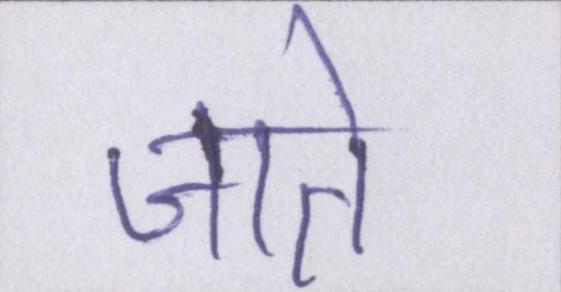



1/1 [==============================] - 0s 25ms/step
predicted text = जाे



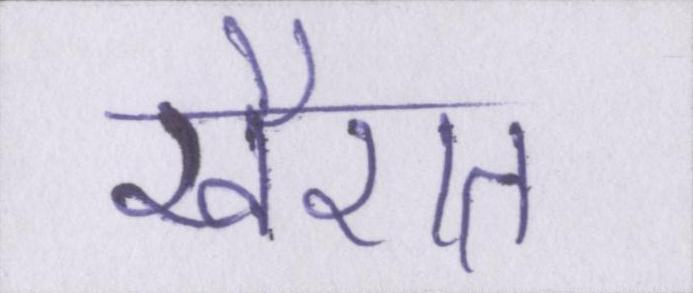



1/1 [==============================] - 0s 21ms/step
predicted text = ख़ैरत



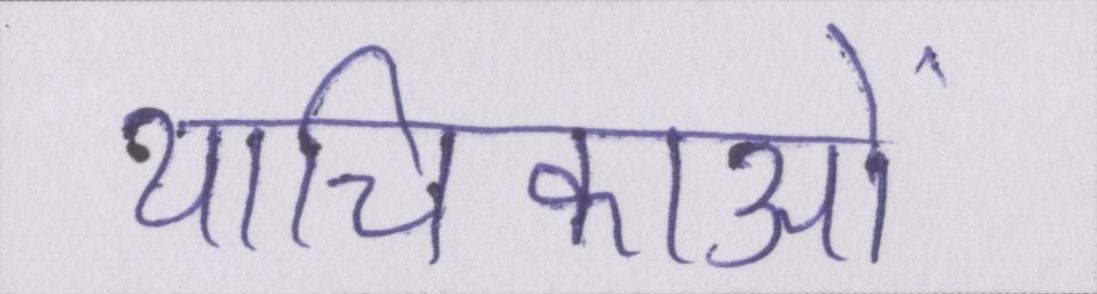



1/1 [==============================] - 0s 19ms/step
predicted text = यधिकाओं



In [29]:
from IPython.display import display
from random import randrange

for i in range(10):
    index = randrange(len(val_path))
    im = Image.open("HindiSeg/"+val_path[index])
    display(im)

    print("\n")

    test_img = pre_process_image(val_path[index])
    predict_output(test_img)

In [30]:
def pre_process_image(path):

#   img = cv2.cvtColor(cv2.imread("HindiSeg/"+path), cv2.COLOR_BGR2GRAY)

  img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
  ### actually returns h, w
  h, w = img.shape

  ### if height less than 32
  if h < 32:
    add_zeros = np.ones((32-h, w)) * 255
    img = np.concatenate((img, add_zeros))
    h = 32

  ## if width less than 128
  if w < 128:
    add_zeros = np.ones((h, 128-w)) * 255
    img = np.concatenate((img, add_zeros), axis=1)
    w = 128

  ### if width is greater than 128 or height greater than 32
  if w > 128 or h > 32:
    img = cv2.resize(img, (128, 32))

    
  img = np.expand_dims(img , axis = 2)

  # Normalize each image
  img = img / 255.
    
  return img

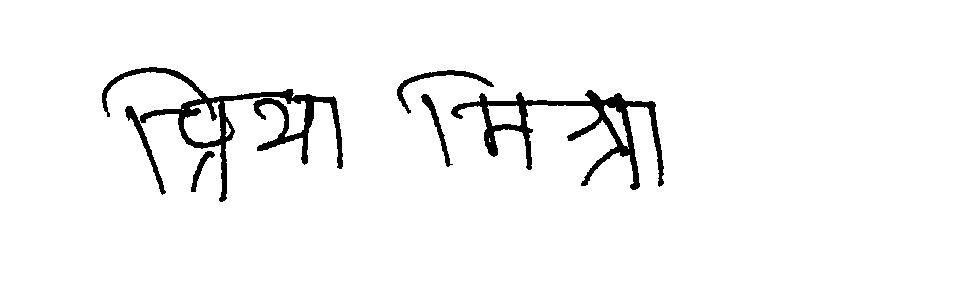

1/1 [==============================] - 0s 18ms/step
predicted text = श्रयश्च्त्रा



In [31]:
test_img = r"D:\MPSeDC\OCR\Hindi-OCR-Words\Img\H-S-140-F-04.tif"
im = Image.open(test_img)
display(im)
test_img = pre_process_image(test_img)
predict_output(test_img)

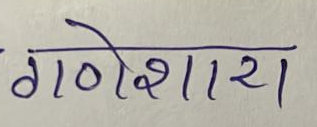

1/1 [==============================] - 0s 25ms/step
predicted text = गजेन्शाथ



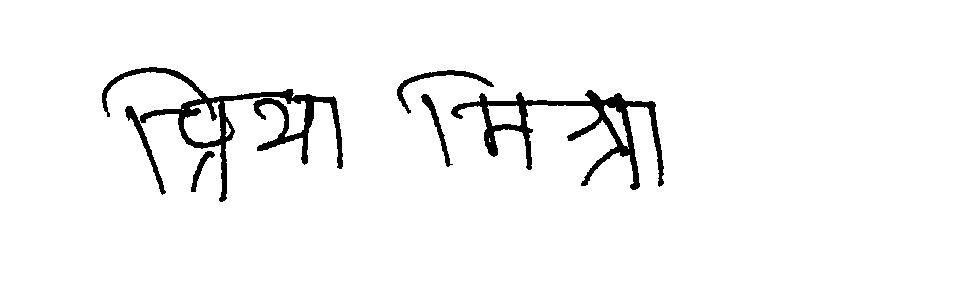

1/1 [==============================] - 0s 26ms/step
predicted text = श्रयश्च्त्रा



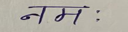

1/1 [==============================] - 0s 24ms/step
predicted text = बगं



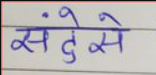

1/1 [==============================] - 0s 18ms/step
predicted text = खंडसे



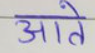

1/1 [==============================] - 0s 30ms/step
predicted text = आते



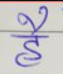

1/1 [==============================] - 0s 34ms/step
predicted text = हँ



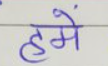

1/1 [==============================] - 0s 19ms/step
predicted text = हमे



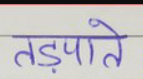

1/1 [==============================] - 0s 20ms/step
predicted text = तड़ांं



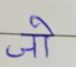

1/1 [==============================] - 0s 24ms/step
predicted text = ज।



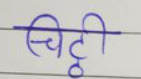

1/1 [==============================] - 0s 25ms/step
predicted text = चिट्टी



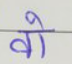

1/1 [==============================] - 0s 19ms/step
predicted text = व।



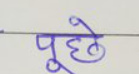

1/1 [==============================] - 0s 22ms/step
predicted text = पूछ



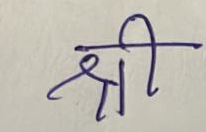

1/1 [==============================] - 0s 17ms/step
predicted text = क््नीी



In [32]:
# run prediction on img folder
for i in os.listdir("Img/"):
    test_img = pre_process_image("Img/"+i)
    im = Image.open("Img/"+i)
    display(im)
    predict_output(test_img)
